In [1]:
# Baseline code:
# https://alvinntnu.github.io/python-notes/nlp/word-embeddings-autoencoder.html

%pip install nltk
%pip install keras


In [3]:
# Importing libraries.
import nltk
import random
import numpy as np
import pandas as pd
from nltk.corpus import brown
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from keras.utils import pad_sequences
from keras import Input, Model, optimizers
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Bidirectional, GRU, LSTM, Embedding, RepeatVector, Dense

In [4]:
# Download the Brown Corpus
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

### Visualizations


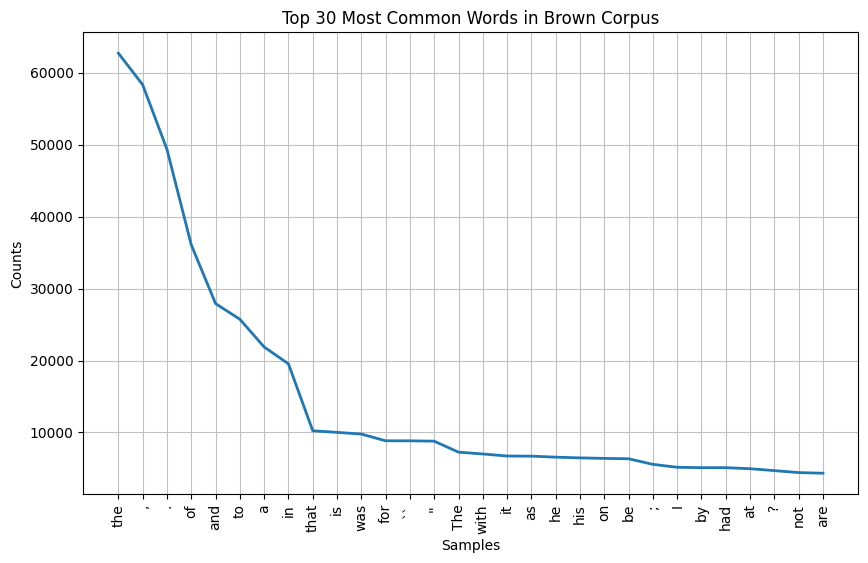

In [5]:
# Get words from the corpus
words = brown.words()

# Calculate frequency distribution
fdist = FreqDist(words)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
fdist.plot(30, title='Top 30 Most Common Words in Brown Corpus')
plt.show()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


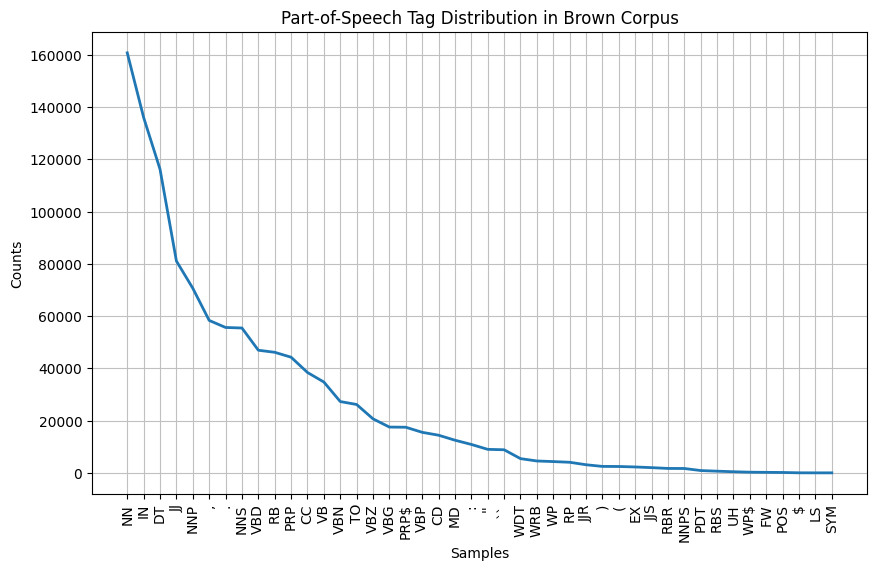

In [6]:
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

# Get words from the corpus
words = brown.words()

# Get tagged words (word, POS) from the corpus
tagged_words = pos_tag(brown.words())

# Get a list of POS tags
pos_tags = [tag for word, tag in tagged_words]

# Calculate frequency distribution of POS tags
pos_fdist = FreqDist(pos_tags)

# Plot the frequency distribution of POS tags
plt.figure(figsize=(10, 6))
pos_fdist.plot(title='Part-of-Speech Tag Distribution in Brown Corpus')
plt.show()

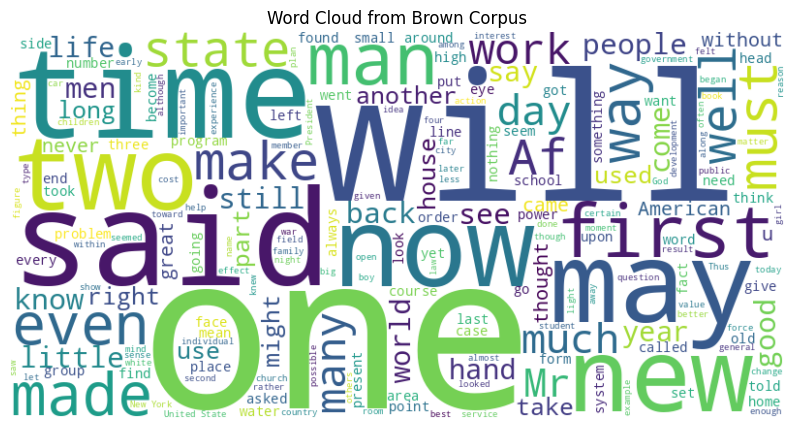

In [7]:
from wordcloud import WordCloud
# Get words from the corpus
words = brown.words()

# Combine words into a single string
text = ' '.join(words)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Brown Corpus')
plt.show()

In [8]:
sents = brown.sents() # Senetences in the corpus # 57340
len(sents)

57340

In [9]:
sents = brown.sents()
maxlen = max([len(s) for s in sents])
print(maxlen)       # Maximum length is sentence is 180.

180


<ipython-input-10-020775dba425>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


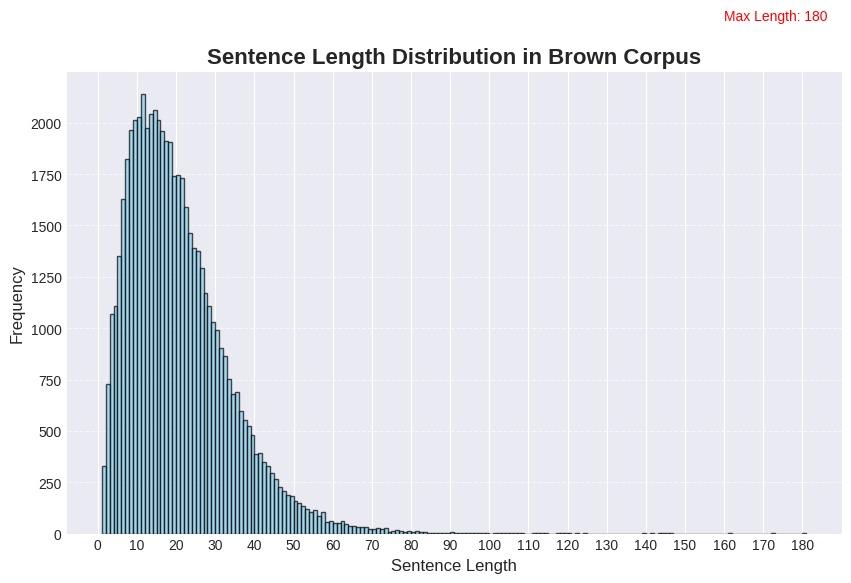

In [10]:
# Calculate sentence lengths
sent_lengths = [len(sent) for sent in sents]

# Get the maximum sentence length
maxlen = max(sent_lengths)

# Customize plot style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 6))

# Plot the sentence length distribution
plt.hist(sent_lengths, bins=range(1, maxlen + 2), edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Sentence Length Distribution in Brown Corpus', fontsize=16, fontweight='bold')
plt.xlabel('Sentence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(0, maxlen + 1, 10), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.text(maxlen - 20, 2500, 'Max Length: {}'.format(maxlen),
         fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Show the plot
plt.show()

In [11]:
vocab = set(brown.words())
num_words = len(vocab)
print(num_words)    # Number of unique words 56057.
print(len(sents))   # Count of senetences 57340.

56057
57340


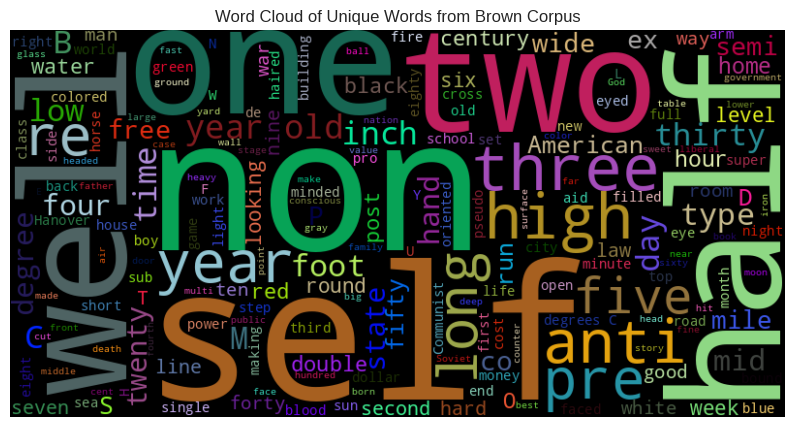

In [12]:
# Define a function to generate random colors
def random_color(word, font_size, position, orientation, font_path, random_state):
    return tuple(random.randint(0, 255) for _ in range(3))

# Combine words into a single string
text = ' '.join(vocab)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', color_func=random_color).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Unique Words from Brown Corpus')
plt.show()

In [13]:
# magic numbers
num_words = 10000 #maximum number of words in the vocabulary .
embed_dim = 256  #dimensionality of the word embeddings.
batch_size = 256  #data samples will be processed in each iteration.
maxlen = 60 #maximum length of input sequences.
epochs = 15   #number of times the entire training dataset will be used to train the model.
workers = 16 #it speed up data processing by performing tasks concurrently.

In [ ]:
# Tokenizing and Padding
tokenizer = Tokenizer(num_words = num_words, split=' ')  #Tokenizer: text into sequence of Tokens.
tokenizer.fit_on_texts(sents) #Fitting the tokenizer on the input text data.
seqs = tokenizer.texts_to_sequences(sents) #converts the list of sentences into sequences of integers.
pad_seqs = pad_sequences(seqs, maxlen) #Pdding the sequeneces upto max Length.

## Model Implementation

### Bidirectional_LSTM

In [23]:
# Encoder Model
encoder_inputs = Input(shape=(maxlen,))
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, mask_zero=False)
x = emb_layer(encoder_inputs)
x = Bidirectional(LSTM(embed_dim, activation='relu'))(x)
seq2seq_encoder_out = Model(inputs=encoder_inputs, outputs=x)(encoder_inputs)

# Decoder Model
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
x = Bidirectional(LSTM(embed_dim, return_sequences=True))(decoded)
decoder_outputs = Dense(num_words, activation='softmax')(x)

# Combining Model and Training
seq2seq_Model_lstm = Model(encoder_inputs, decoder_outputs)
seq2seq_Model_lstm.compile(optimizer="Adam", \
        loss='sparse_categorical_crossentropy', metrics=['accuracy'])
seq2seq_Model_lstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 model_1 (Functional)        (None, 512)               3610624   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 60, 512)          0         
 or)                                                             
                                                                 
 bidirectional_7 (Bidirectio  (None, 60, 512)          1574912   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 60, 10000)         5130000   
                                                                 
Total params: 10,315,536
Trainable params: 10,315,536
Non-t

In [24]:
from keras.callbacks import EarlyStopping
Early_St1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [25]:
import time

# Record the start time
start_time = time.time()


print('Model fit (epochs=%d)' % epochs)
history = seq2seq_Model_lstm.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          validation_split=0.2, #validation_split=1/epochs
          workers=workers,
          callbacks=[Early_St1],
          use_multiprocessing=True,
          epochs=epochs)

# Calculate and display the training time
end_time = time.time()
training_time_seconds = end_time - start_time

# Convert training time to hours and minutes
training_hours = int(training_time_seconds // 3600)
training_minutes = int((training_time_seconds % 3600) // 60)

print('Training time: {} hours and {} minutes'.format(training_hours, training_minutes))

Model fit (epochs=15)
Epoch 1/15
1434/1434 [==============================] - 2253s 2s/step - loss: 2.8317 - accuracy: 0.6839 - val_loss: 2.1620 - val_accuracy: 0.7687
Epoch 2/15
1434/1434 [==============================] - 2291s 2s/step - loss: 2.7739 - accuracy: 0.6859 - val_loss: 2.1381 - val_accuracy: 0.7687
Epoch 3/15
1434/1434 [==============================] - 2255s 2s/step - loss: 2.7701 - accuracy: 0.6859 - val_loss: 2.1157 - val_accuracy: 0.7687
Epoch 4/15
1434/1434 [==============================] - 2222s 2s/step - loss: 2.7670 - accuracy: 0.6859 - val_loss: 2.1467 - val_accuracy: 0.7687
Epoch 5/15
1434/1434 [==============================] - 2232s 2s/step - loss: 2.7657 - accuracy: 0.6859 - val_loss: 2.1703 - val_accuracy: 0.7687
Epoch 5: early stopping
Training time: 3 hours and 7 minutes


In [26]:
# evaluate the autoencoder (Warning: training accuracy)
print('Model evaluation')
_, accuracy = seq2seq_Model_lstm.evaluate(pad_seqs, np.expand_dims(pad_seqs, -1),
                               use_multiprocessing=True,
                               workers=workers)
print('Training accuracy: %f' % (accuracy*100))

Model evaluation
1792/1792 [==============================] - 1005s 561ms/step - loss: 2.6530 - accuracy: 0.7025
Training accuracy: 70.246017


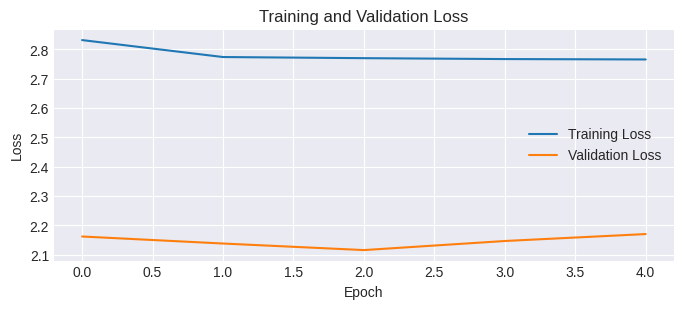

In [27]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

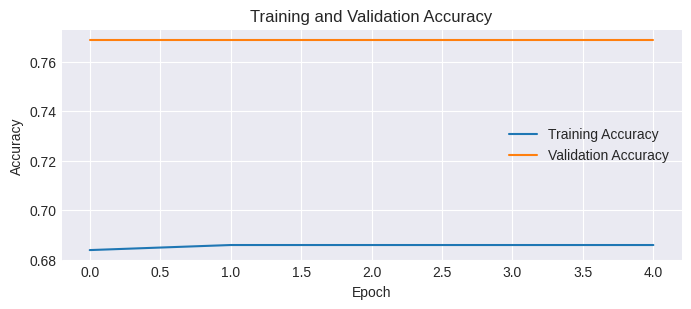

In [28]:
# Plot training and validation accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Three Bidirectional LSTM

In [15]:
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
state_h1 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM', return_sequences=True))(x)
state_h2 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM',return_sequences=True))(state_h1)
state_h3 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM'))(state_h2)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h3, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [16]:
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

In [17]:
# Combining Model and Training
seq2seq_Model = Model(encoder_inputs, decoder_outputs)
seq2seq_Model.compile(optimizer="Adam", \
        loss='sparse_categorical_crossentropy', metrics=['accuracy'])
seq2seq_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-Input (InputLayer)  [(None, 60)]              0         
                                                                 
 Encoder-Model (Functional)  (None, 256)               3742720   
                                                                 
 repeat_vector (RepeatVector  (None, 60, 256)          0         
 )                                                               
                                                                 
 bidirectional_5 (Bidirectio  (None, 60, 256)          394240    
 nal)                                                            
                                                                 
 Final-Output-Dense-before (  (None, 60, 10000)        2570000   
 Dense)                                                          
                                                             

In [18]:
from keras.callbacks import EarlyStopping
Early_St1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [19]:
import time

# Record the start time
start_time = time.time()


print('Model fit (epochs=%d)' % epochs)
history = seq2seq_Model.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          validation_split=0.2, #validation_split=1/epochs
          workers=workers,
          callbacks=[Early_St1],
          use_multiprocessing=True,
          epochs=epochs)

# Calculate and display the training time
end_time = time.time()
training_time_seconds = end_time - start_time

# Convert training time to hours and minutes
training_hours = int(training_time_seconds // 3600)
training_minutes = int((training_time_seconds % 3600) // 60)

print('Training time: {} hours and {} minutes'.format(training_hours, training_minutes))

Model fit (epochs=15)
Epoch 1/15
1434/1434 [==============================] - 1761s 1s/step - loss: 2.2438 - accuracy: 0.6999 - val_loss: 1.5061 - val_accuracy: 0.7834
Epoch 2/15
1434/1434 [==============================] - 1739s 1s/step - loss: 2.0482 - accuracy: 0.7092 - val_loss: 1.4273 - val_accuracy: 0.7925
Epoch 3/15
1434/1434 [==============================] - 1782s 1s/step - loss: 1.9861 - accuracy: 0.7130 - val_loss: 1.3776 - val_accuracy: 0.7961
Epoch 4/15
1434/1434 [==============================] - 1750s 1s/step - loss: 1.9347 - accuracy: 0.7154 - val_loss: 1.3478 - val_accuracy: 0.7979
Epoch 5/15
1434/1434 [==============================] - 1748s 1s/step - loss: 1.8771 - accuracy: 0.7195 - val_loss: 1.3000 - val_accuracy: 0.8029
Epoch 6/15
1434/1434 [==============================] - 1726s 1s/step - loss: 1.7952 - accuracy: 0.7259 - val_loss: 1.2477 - val_accuracy: 0.8085
Epoch 7/15
1434/1434 [==============================] - 1757s 1s/step - loss: 1.7211 - accuracy: 0.731

In [20]:
# evaluate the autoencoder (Warning: training accuracy)
print('Model evaluation')
_, accuracy = seq2seq_Model.evaluate(pad_seqs, np.expand_dims(pad_seqs, -1),
                               use_multiprocessing=True,
                               workers=workers)
print('Training accuracy: %f' % (accuracy*100))

Model evaluation
1792/1792 [==============================] - 823s 459ms/step - loss: 1.2277 - accuracy: 0.7818
Training accuracy: 78.183204


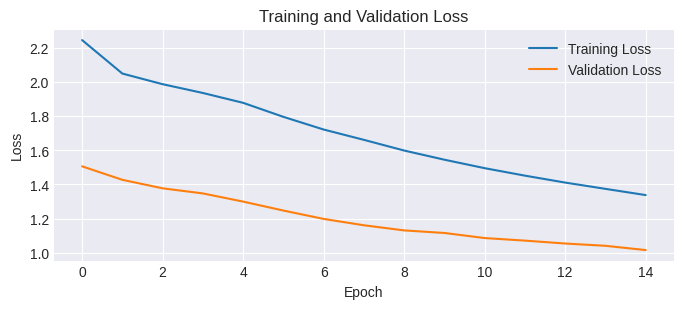

In [21]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

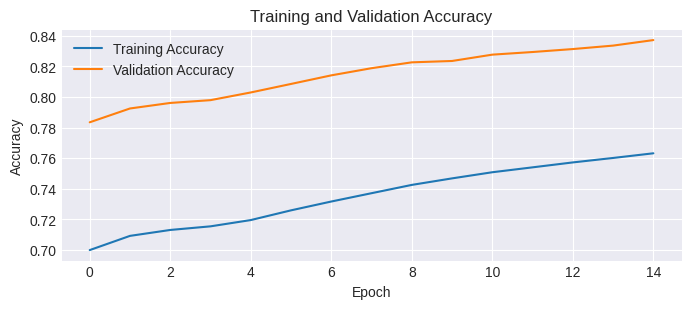

In [22]:
# Plot training and validation accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Two Bidirectional LSTM.

In [25]:
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
state_h1 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM', return_sequences=True))(x)
state_h2 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM'))(state_h1)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h2, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

In [26]:
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_lstm1 = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm2 = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm_output = decoder_lstm2(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

In [27]:
# Combining Model and Training
seq2seq_Model2 = Model(encoder_inputs, decoder_outputs)
seq2seq_Model2.compile(optimizer="Adam", \
        loss='sparse_categorical_crossentropy', metrics=['accuracy'])
seq2seq_Model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-Input (InputLayer)  [(None, 60)]              0         
                                                                 
 Encoder-Model (Functional)  (None, 256)               3348480   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 60, 256)          0         
 or)                                                             
                                                                 
 bidirectional_11 (Bidirecti  (None, 60, 256)          394240    
 onal)                                                           
                                                                 
 Final-Output-Dense-before (  (None, 60, 10000)        2570000   
 Dense)                                                          
                                                           

In [28]:
from keras.callbacks import EarlyStopping
Early_St1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [29]:
import time

# Record the start time
start_time = time.time()


print('Model fit (epochs=%d)' % epochs)
history = seq2seq_Model2.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          validation_split=0.2, #validation_split=1/epochs
          workers=workers,
          callbacks=[Early_St1],
          use_multiprocessing=True,
          epochs=epochs)

# Calculate and display the training time
end_time = time.time()
training_time_seconds = end_time - start_time

# Convert training time to hours and minutes
training_hours = int(training_time_seconds // 3600)
training_minutes = int((training_time_seconds % 3600) // 60)

print('Training time: {} hours and {} minutes'.format(training_hours, training_minutes))

Model fit (epochs=15)
Epoch 1/15
1434/1434 [==============================] - 1458s 1s/step - loss: 2.2325 - accuracy: 0.7016 - val_loss: 1.5293 - val_accuracy: 0.7827
Epoch 2/15
1434/1434 [==============================] - 1448s 1s/step - loss: 2.0625 - accuracy: 0.7075 - val_loss: 1.5029 - val_accuracy: 0.7856
Epoch 3/15
1434/1434 [==============================] - 1483s 1s/step - loss: 2.0166 - accuracy: 0.7120 - val_loss: 1.4353 - val_accuracy: 0.7897
Epoch 4/15
1434/1434 [==============================] - 1474s 1s/step - loss: 1.9666 - accuracy: 0.7148 - val_loss: 1.3767 - val_accuracy: 0.7966
Epoch 5/15
1434/1434 [==============================] - 1472s 1s/step - loss: 1.9038 - accuracy: 0.7208 - val_loss: 1.3575 - val_accuracy: 0.7959
Epoch 6/15
1434/1434 [==============================] - 1449s 1s/step - loss: 1.8406 - accuracy: 0.7250 - val_loss: 1.2906 - val_accuracy: 0.8066
Epoch 7/15
1434/1434 [==============================] - 1434s 1s/step - loss: 1.7676 - accuracy: 0.729

In [31]:
# evaluate the autoencoder (Warning: training accuracy)
print('Model evaluation')
_, accuracy = seq2seq_Model2.evaluate(pad_seqs, np.expand_dims(pad_seqs, -1),
                               use_multiprocessing=True,
                               workers=workers)
print('Training accuracy: %f' % (accuracy*100))

Model evaluation
1792/1792 [==============================] - 768s 429ms/step - loss: 1.2044 - accuracy: 0.7833
Training accuracy: 78.330427


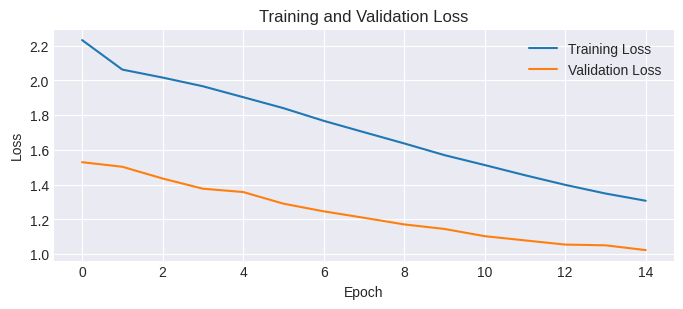

In [32]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

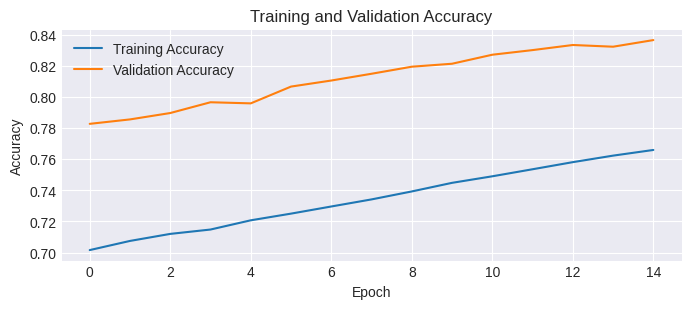

In [33]:
# Plot training and validation accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Four Bidirectional-LSTM

In [2]:
encoder_inputs = Input(shape=(maxlen,), name='Encoder-Input')
emb_layer = Embedding(num_words, embed_dim,input_length = maxlen, name='Body-Word-Embedding', mask_zero=False)
x = emb_layer(encoder_inputs)
state_h1 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM', return_sequences=True))(x)
state_h2 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM', return_sequences=True))(state_h1)
state_h3 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM',return_sequences=True))(state_h2)
state_h4 = Bidirectional(LSTM(128, activation='relu', name='Encoder-Last-LSTM'))(state_h3)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h4, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

NameError: ignored

In [17]:
decoded = RepeatVector(maxlen)(seq2seq_encoder_out)
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm = Bidirectional(LSTM(128, return_sequences=True, name='Decoder-LSTM-before'))
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(num_words, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

In [19]:
# Combining Model and Training
seq2seq_Model3 = Model(encoder_inputs, decoder_outputs)
seq2seq_Model3.compile(optimizer="Adam", \
        loss='sparse_categorical_crossentropy', metrics=['accuracy'])
seq2seq_Model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-Input (InputLayer)  [(None, 60)]              0         
                                                                 
 Encoder-Model (Functional)  (None, 256)               4136960   
                                                                 
 repeat_vector (RepeatVector  (None, 60, 256)          0         
 )                                                               
                                                                 
 bidirectional_7 (Bidirectio  (None, 60, 256)          394240    
 nal)                                                            
                                                                 
 Final-Output-Dense-before (  (None, 60, 10000)        2570000   
 Dense)                                                          
                                                           

In [20]:
from keras.callbacks import EarlyStopping
Early_St1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [21]:
import time

# Record the start time
start_time = time.time()


print('Model fit (epochs=%d)' % epochs)
history = seq2seq_Model3.fit(pad_seqs, np.expand_dims(pad_seqs, -1),
          validation_split=0.2, #validation_split=1/epochs
          workers=workers,
          callbacks=[Early_St1],
          use_multiprocessing=True,
          epochs=epochs)

# Calculate and display the training time
end_time = time.time()
training_time_seconds = end_time - start_time

# Convert training time to hours and minutes
training_hours = int(training_time_seconds // 3600)
training_minutes = int((training_time_seconds % 3600) // 60)

print('Training time: {} hours and {} minutes'.format(training_hours, training_minutes))

Model fit (epochs=15)
Epoch 1/15
1434/1434 [==============================] - 1914s 1s/step - loss: 2.2317 - accuracy: 0.7006 - val_loss: 1.5080 - val_accuracy: 0.7809
Epoch 2/15
1434/1434 [==============================] - 1886s 1s/step - loss: 2.0650 - accuracy: 0.7075 - val_loss: 1.4990 - val_accuracy: 0.7824
Epoch 3/15
1434/1434 [==============================] - 1894s 1s/step - loss: 2.0500 - accuracy: 0.7085 - val_loss: 1.4734 - val_accuracy: 0.7873
Epoch 4/15
1434/1434 [==============================] - 1871s 1s/step - loss: nan - accuracy: 0.6873 - val_loss: nan - val_accuracy: 0.7544
Epoch 5/15
1434/1434 [==============================] - 1845s 1s/step - loss: nan - accuracy: 0.6716 - val_loss: nan - val_accuracy: 0.7544
Epoch 5: early stopping
Training time: 2 hours and 36 minutes


In [23]:
# evaluate the autoencoder (Warning: training accuracy)
print('Model evaluation')
_, accuracy = seq2seq_Model3.evaluate(pad_seqs, np.expand_dims(pad_seqs, -1),
                               use_multiprocessing=True,
                               workers=workers)
print('Training accuracy: %f' % (accuracy*100))

Model evaluation
1792/1792 [==============================] - 908s 507ms/step - loss: nan - accuracy: 0.6881
Training accuracy: 68.813193


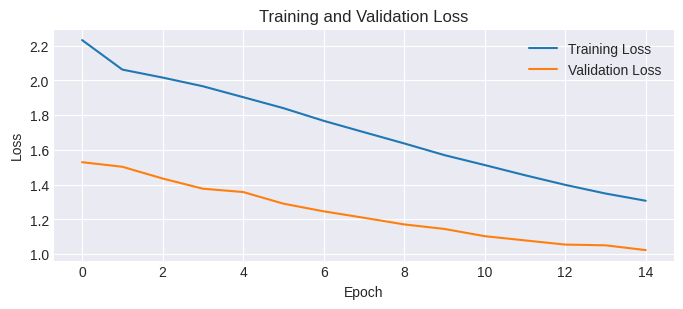

In [34]:
# Plot training and validation loss curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

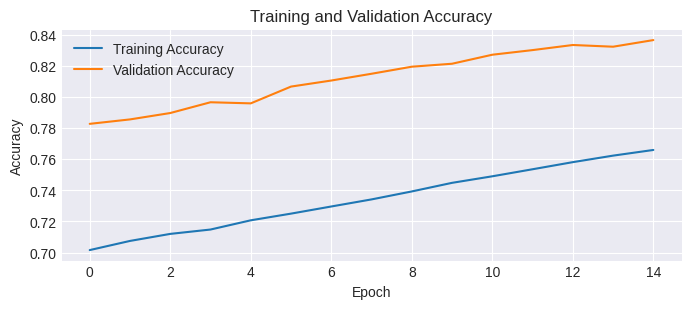

In [35]:
# Plot training and validation accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()